In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library

In [ ]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import datetime
global_start = datetime.datetime.now();

## Load Dataset

In [ ]:
# load data annotasi, image, train dan submission

annotations_directory = "/content/drive/MyDrive/Dataset/Tubes/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "/content/drive/MyDrive/Dataset/Tubes/Medical mask/Medical mask/Medical Mask/images"
df_train = pd.read_csv("/content/drive/MyDrive/Dataset/Tubes/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Dataset/Tubes/submission.csv")

## Load Architecture SSD

In [ ]:
cvNet = cv2.dnn.readNetFromCaffe('/content/drive/MyDrive/Dataset/Tubes/architecture.txt',
                                 '/content/drive/MyDrive/Dataset/Tubes/weights.caffemodel')

## Panggil fungsi JSON dan gamma

In [ ]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [ ]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

## Preprocessing

In [ ]:
jsonfiles= []
for i in os.listdir(annotations_directory):
    jsonfiles.append(getJSON(os.path.join(annotations_directory,i)))
jsonfiles[0]

{'Annotations': [{'Attributes': {},
   'BoundingBox': [3574, 991, 4021, 1529],
   'Confidence': 1,
   'ID': 253835550837702496,
   'classname': 'face_with_mask',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [3598, 1232, 3857, 1476],
   'Confidence': 1,
   'ID': 923094518388738176,
   'classname': 'mask_surgical',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [3588, 1158, 3891, 1295],
   'Confidence': 1,
   'ID': 343408773037608768,
   'classname': 'eyeglasses',
   'isProtected': False}],
 'FileName': '5201.jpg',
 'NumOfAnno': 3}

In [ ]:
df_train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


## Labeling

In [ ]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df_train["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(annotations_directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)   

In [ ]:
len(data)

5749

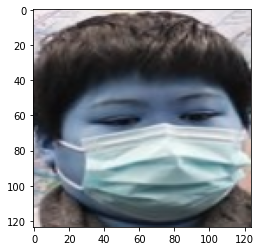

In [ ]:
data[1][0]
plt.imshow(data[1][0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


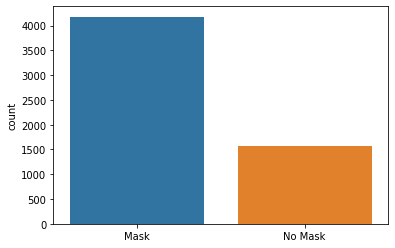

In [ ]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [ ]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

In [ ]:
X[0].shape

(124, 124, 3)

In [ ]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [ ]:
np.unique(Y)

array([0, 1])

In [ ]:
Y.shape

(5749,)

## Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                        

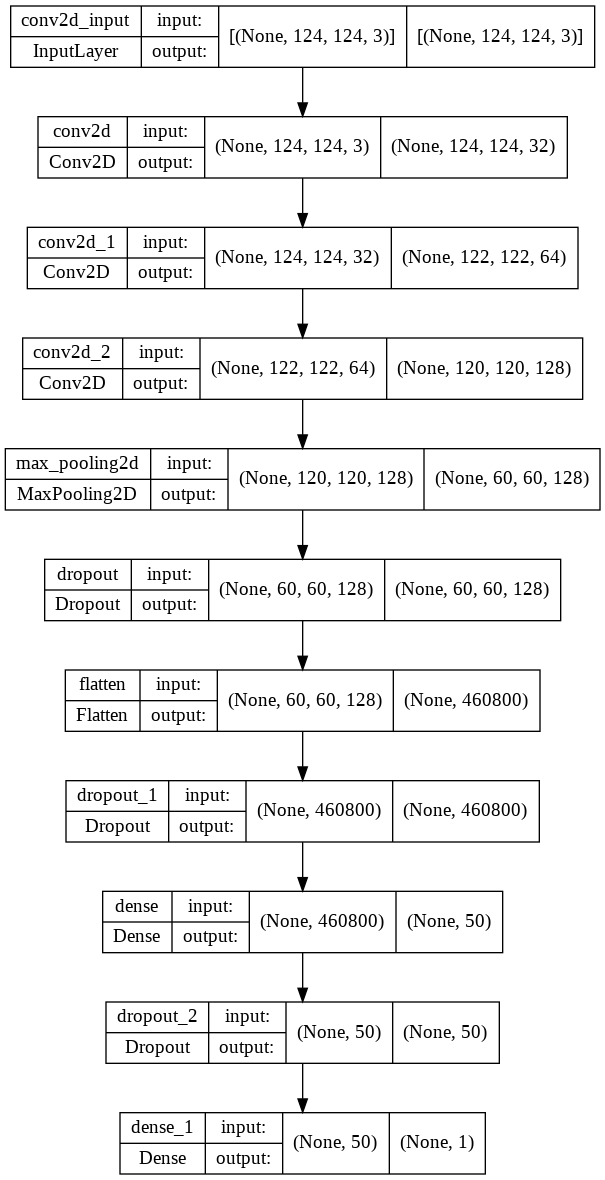

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model=model, show_shapes=True)

## Optimizer

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='SGD' ,metrics=['accuracy'])

## Dataset Split

In [ ]:
(x_train,x_test,y_train,y_test)=train_test_split(X, Y, stratify=Y,train_size=0.8)

## Data Generator for Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
# datagen.fit(xtrain)

## Training

In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=x_train.shape[0]//32,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_test, y_test))
print(datetime.datetime.now()-global_start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
143/143 [==============================] - 37s 168ms/step - loss: 0.4985 - accuracy: 0.7508 - val_loss: 0.3417 - val_accuracy: 0.8930
Epoch 2/30
143/143 [==============================] - 21s 148ms/step - loss: 0.3394 - accuracy: 0.8581 - val_loss: 0.2688 - val_accuracy: 0.8965
Epoch 3/30
143/143 [==============================] - 21s 149ms/step - loss: 0.2908 - accuracy: 0.8774 - val_loss: 0.2631 - val_accuracy: 0.8913
Epoch 4/30
143/143 [==============================] - 21s 148ms/step - loss: 0.2913 - accuracy: 0.8754 - val_loss: 0.2403 - val_accuracy: 0.9009
Epoch 5/30
143/143 [==============================] - 21s 149ms/step - loss: 0.2746 - accuracy: 0.8868 - val_loss: 0.2376 - val_accuracy: 0.8948
Epoch 6/30
143/143 [==============================] - 23s 160ms/step - loss: 0.2757 - accuracy: 0.8850 - val_loss: 0.2778 - val_accuracy: 0.8783
Epoch 7/30
143/143 [==============================] - 21s 147ms/step - loss: 0.2683 - accuracy: 0.8813 - val_loss: 0.2159 - val_ac

In [ ]:
print('Training Evaluation')
loss, acc = model.evaluate(x_train, y_train)
print('Loss\t\t:', loss)
print('Accuracy\t:', acc)

Training Evaluation
144/144 [==============================] - 5s 32ms/step - loss: 0.1492 - accuracy: 0.9417
Loss		: 0.14923182129859924
Accuracy	: 0.9417264461517334


In [ ]:
print('Testing Evaluation')
loss, acc = model.evaluate(x_test, y_test)
print('Loss\t\t:', loss)
print('Accuracy\t:', acc)

Testing Evaluation
36/36 [==============================] - 1s 34ms/step - loss: 0.1616 - accuracy: 0.9339
Loss		: 0.1616039276123047
Accuracy	: 0.9339130520820618


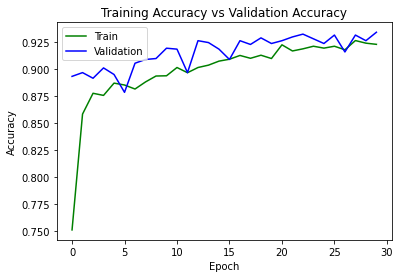

In [ ]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

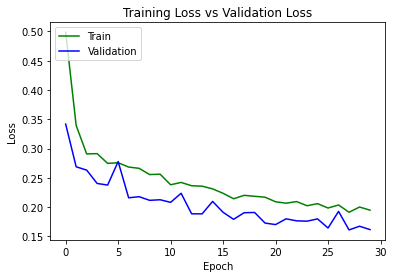

In [ ]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
prediksi = model.predict(x_test.astype('float32'))
pred = np.argmax(prediksi, axis = 1)
cm = confusion_matrix(y_test, pred)
print('Classification Report')
print(classification_report(y_test, pred, target_names=labels))

Classification Report
              precision    recall  f1-score   support

        mask       0.73      1.00      0.84       836
without mask       0.00      0.00      0.00       314

    accuracy                           0.73      1150
   macro avg       0.36      0.50      0.42      1150
weighted avg       0.53      0.73      0.61      1150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Testing

In [ ]:
print(len(df_test["name"]),len(df_test["name"].unique()))

8142 1698


In [ ]:
test_images = ['0045.jpg','0058.jpg', '0023.jpg','0025.jpg','0353.jpg','1374.jpg']

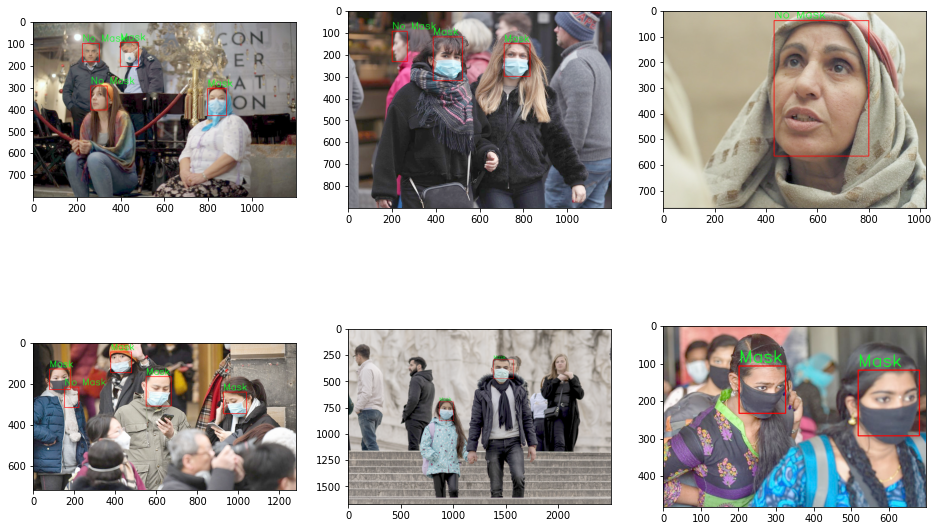

In [ ]:
gamma = 2.0
fig = plt.figure(figsize = (16,16))
rows = 3
cols = 3
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()